In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import colorcet as cc

from norm import cut_norm,interpolate_and_sample

def readsheet(sheetname,excel_file_path):
    data = pd.read_excel(excel_file_path,sheet_name=sheetname)
    columns_to_remove = ['Temp. [°C]']
    data.drop(columns=columns_to_remove, inplace=True)
    return data

In [ ]:
#SUM ALL THE DATA
excel_file_path = 'WT_in_LB_data_Omar_s1.XLSX'
lsheetnames = ['P0002','P0005','P0008','P0012','P0030']
numbers=[0,1,2,3,4]
excel_file_path2 = 'different_conditions_data_Omar_s2.XLSX'
lsheetnames2 = ['P12_WT','P13_TolC_KO','P16_AcrD_KO','P17_AcrA_KO','P18_AcrB_KO','P24_AcrBD_KO']
numbers2=[0,1,2,3,4,5]
split = [n.split('_') for n in lsheetnames2]
gene= [sublist[1] for sublist in split]         #The strain: WT,AcrA,AcrB,etc...
custom_palette=sns.color_palette(cc.glasbey) 
lsheetnames3 = ['P25_kan_2_50','P27_kan_1_25','P28_kan','P30_kan_2_50']
numbers3=[0,1,2,3]

legend_added = set()  # To keep track of colors for which legend entry is added
time_to_cut=175000
nvalues_to_interpolate=299
sum_data=pd.DataFrame()
sum_data2=pd.DataFrame()
sum_data3=pd.DataFrame()
batches=[]
batch_color_map = {}
color_index = 0
experiments=[]               

for sheetname,i in zip(lsheetnames,numbers):
    df = readsheet(sheetname, excel_file_path)
    df=cut_norm(df,time_to_cut)
    df = interpolate_and_sample(df,time_to_cut,nvalues_to_interpolate)
    Time=df['Time [s]'].values
    for column,j in zip(df.columns.values[2:],enumerate(df.columns.values[2:])):
        new_column_name = f'WT_LB_{i}_{j[0]}'
        sum_data[new_column_name]=df[column]
        batch=f'WT_LB_{i}'
        batches.append(batch)
        for batch_ in batches:
            if batch_ not in batch_color_map:
                batch_color_map[batch_] = custom_palette[color_index]
                color_index = (color_index + 1) % len(custom_palette)
        color = batch_color_map[batch]
        # Add legend entry only if the color is not yet added to the legend
        if color not in legend_added:
            legend_added.add(color) 
            experiments.append(batch)


for sheetname2,i in zip(lsheetnames2,numbers2):
    df = readsheet(sheetname2,excel_file_path2)
    df=cut_norm(df,time_to_cut)
    df = interpolate_and_sample(df,time_to_cut,nvalues_to_interpolate)
    split_column_names = [name.split('_') for name in df.columns.values[2:]]
    drugs=[sublist[0] for sublist in split_column_names]
    plate_indexes=[sublist[1] for sublist in split_column_names]
    sum_split=[name.split('_') for name in sum_data.columns]
    joined_sum_split = ['_'.join(parts[:3]) for parts in sum_split]
    for column,drug,plate_index in zip(df.columns.values[2:],drugs,plate_indexes):
        aux=0
        for j in range (len(joined_sum_split)):
            if joined_sum_split[j]==f'{gene[i]}_{drug}_{aux}':
                aux+=1    
        new_column_name = f'{gene[i]}_{drug}_{aux}_{plate_index}'
        sum_data2[new_column_name]=df[column]
        batch=f'{gene[i]}_{drug}_{aux}'
        batches.append(batch)
        for batch_ in batches:
            if batch_ not in batch_color_map:
                batch_color_map[batch_] = custom_palette[color_index]
                color_index = (color_index + 1) % len(custom_palette)
        color = batch_color_map[batch]
        if color not in legend_added:
            legend_added.add(color)  
            experiments.append(batch)

for sheetname3 in lsheetnames3:
    df = readsheet(sheetname3,excel_file_path2)
    df=cut_norm(df,time_to_cut)
    df = interpolate_and_sample(df,time_to_cut,nvalues_to_interpolate)
    split_column_names = [name.split('_') for name in df.columns.values[2:]]
    strain_drugs=['_'.join(parts[:2]) for parts in split_column_names]
    plate_indexes=[sublist[2] for sublist in split_column_names]
    sum_split=[name.split('_') for name in sum_data.columns]
    joined_sum_split = ['_'.join(parts[:3]) for parts in sum_split]
    sum_split2=[name.split('_') for name in sum_data2.columns]
    joined_sum_split2 = ['_'.join(parts2[:3]) for parts2 in sum_split2]
    sum_split3=[name.split('_') for name in sum_data3.columns]
    joined_sum_split3 = ['_'.join(parts[:3]) for parts in sum_split3]
    for column,strain_drug,plate_index in zip(df.columns.values[2:],strain_drugs,plate_indexes):
        aux=0
        for j in range (len(joined_sum_split)):
            if joined_sum_split[j]==f'{strain_drug}_{aux}':
                aux+=1   
        for k in range (len(joined_sum_split2)):
            if joined_sum_split2[k]==f'{strain_drug}_{aux}':
                aux+=1 
        for l in range (len(joined_sum_split3)):
            if joined_sum_split3[l]==f'{strain_drug}_{aux}':
                aux+=1       
        new_column_name = f'{strain_drug}_{aux}_{plate_index}'
        sum_data3[new_column_name]=df[column]
        batch=f'{strain_drug}_{aux}'
        batches.append(batch)
        for batch in batches:
            if batch not in batch_color_map:
                batch_color_map[batch] = custom_palette[color_index]
                color_index = (color_index + 1) % len(custom_palette)
        color = batch_color_map[batch]
        if color not in legend_added:
            legend_added.add(color) 
            experiments.append(batch)

total_data = pd.concat([sum_data, sum_data2,sum_data3], axis=1)

In [3]:
#Reorder the data by drugs/strains
train_data=pd.DataFrame()
test_data=pd.DataFrame()
batches_test=[]
batches_train=[]
np.random.seed(4)

columns=total_data.columns[:]
num_list = list(range(len(batches)))

experiments2=[]
split_experiments=[name.split('_') for name in experiments]
#experiment_strains=[sublist[0] for sublist in split_experiments] 
experiment_drugs=[sublist[1] for sublist in split_experiments]
batches2=[]
parts=[name.split('_') for name in batches]
batches2=[sublist[1] for sublist in parts]      #[1] for drugs, [0] for strain
print(len(batches2))

for experiment_drug in experiment_drugs:
    if experiment_drug not in experiments2:
        experiments2.append(experiment_drug)

print(len(experiments2),experiments2)

#Select the test_data and the train_data, 15% splitting
for experiment in experiments2:
    columns_to_select=[]
    for batch,i in zip(batches2,num_list):
        if batch==experiment:
            columns_to_select.append(columns[i])
             
    num_columns_to_select = int(len(columns_to_select) * 0.15)        
    test_columns = np.random.choice(columns_to_select, num_columns_to_select,replace=False)
    batches_test.extend([experiment] * len(test_columns))
    test_columns_data = total_data[test_columns]
    train_columns = [col for col in columns_to_select if col not in test_columns]
    train_columns_data = total_data[train_columns]
    print(len(test_columns),len(columns_to_select),num_columns_to_select,len(train_columns)+len(test_columns))
    test_data = pd.concat([test_data, test_columns_data], axis=1)
    train_data = pd.concat([train_data, train_columns_data], axis=1)
    batches_train.extend([experiment] * len(train_columns))

print(test_data.shape,train_data.shape)
print('The number of total growth curves is:',len(batches_test),len(batches_train))         

train_data_T=train_data.T
test_data_T=test_data.T
X_train=train_data_T.values
X_test=test_data_T.values
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

custom_palette=sns.color_palette(cc.glasbey,len(batches_test)) 

816
16 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00', 'K1.25&M0.25', 'K1.25&M0.50', 'K1.25&M1.00', 'K2.50&M0.25', 'K2.50&M0.50', 'K2.50&M1.00', 'K3.75&M0.25', 'K3.75&M0.50', 'K3.75&M1.00']
29 195 29 195
14 98 14 98
22 149 22 149
6 44 6 44
4 32 4 32
4 32 4 32
4 32 4 32
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
(100, 110) (100, 706)
The number of total growth curves is: 110 706


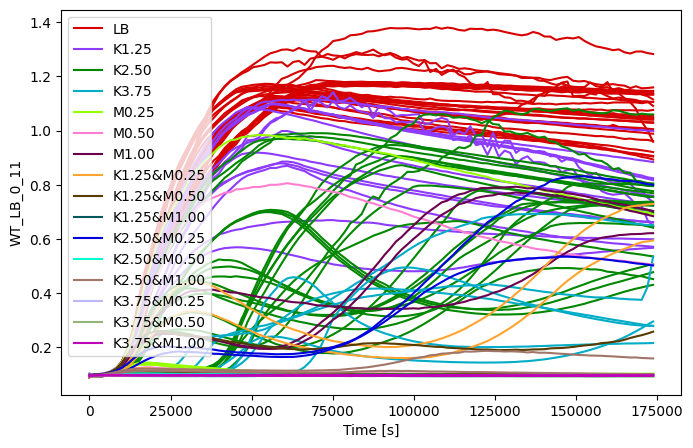

In [6]:
fig, ax = plt.subplots(1,1,figsize=[8,5])
custom_palette=sns.color_palette(cc.glasbey,len(experiments2)) 

total_data['Time [s]'] = Time
test_data['Time [s]'] = Time
train_data['Time [s]'] = Time
legend_added = set()  
batch_color_map = {}
color_index = 0
for batch in batches2:
    if batch not in batch_color_map:
        batch_color_map[batch] = custom_palette[color_index]
        color_index = (color_index + 1) % len(custom_palette)

for column,batch in zip(test_data.columns.values[:len(batches_test)],batches_test):
    color = batch_color_map[batch]
    if color not in legend_added:
        sns.lineplot(data=test_data, x=test_data['Time [s]'], y=column,ax=ax,color=color,label=batch)
        legend_added.add(color)  # Add the color to the set to indicate the legend entry is added
    else:
        sns.lineplot(data=test_data, x=test_data['Time [s]'], y=column,ax=ax,color=color)

# for column,batch in zip(total_data.columns.values[:len(batches2)],batches2):
#     color = batch_color_map[batch]
#     if(batch=='K1.25'):
#         if color not in legend_added:
#             sns.lineplot(data=total_data, x=total_data['Time [s]'], y=column,ax=ax,color=color,label=batch)
#             legend_added.add(color)  # Add the color to the set to indicate the legend entry is added
#         else:
#             sns.lineplot(data=total_data, x=total_data['Time [s]'], y=column,ax=ax,color=color)



ax.legend()

In [5]:
# Defining Autoencoder ARCHITECTURES   
class Autoencoder1(nn.Module):
   def __init__(self, input_size, encoding_dim, hidden_dim1, hidden_dim2):
       super(Autoencoder1, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, hidden_dim1),
           nn.ReLU(),
           nn.Linear(hidden_dim1, hidden_dim2),
           nn.ReLU(),
           nn.Linear(hidden_dim2, encoding_dim),
           nn.ReLU()
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, hidden_dim2),
           nn.ReLU(),
           nn.Linear(hidden_dim2, hidden_dim1),
           nn.ReLU(),
           nn.Linear(hidden_dim1, input_size),
           nn.ReLU()
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

class Autoencoder2(nn.Module):
   def __init__(self, input_size, encoding_dim, hidden_dim1, hidden_dim2):
       super(Autoencoder2, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, hidden_dim1),
           nn.ReLU(),
           nn.Linear(hidden_dim1, hidden_dim2),
           nn.ReLU(),
           nn.Linear(hidden_dim2, encoding_dim),
           nn.Sigmoid()
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, hidden_dim2),
           nn.ReLU(),
           nn.Linear(hidden_dim2, hidden_dim1),
           nn.ReLU(),
           nn.Linear(hidden_dim1, input_size),
           nn.Sigmoid()
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

class Autoencoder3(nn.Module):
   def __init__(self, input_size, encoding_dim, hidden_dim1, hidden_dim2):
       super(Autoencoder3, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, hidden_dim1),
           nn.ReLU(),
           nn.Linear(hidden_dim1, hidden_dim2),
           nn.ReLU(),
           nn.Linear(hidden_dim2, encoding_dim),
           nn.Sigmoid()
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, hidden_dim2),
           nn.ReLU(),
           nn.Linear(hidden_dim2, hidden_dim1),
           nn.ReLU(),
           nn.Linear(hidden_dim1, input_size),
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x
   
class Autoencoder4(nn.Module):
   def __init__(self, input_size, encoding_dim , hidden_dim1, hidden_dim2):
       super(Autoencoder4, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, hidden_dim1),
           nn.Sigmoid(),
           nn.Linear(hidden_dim1, hidden_dim2),
           nn.Sigmoid(),
           nn.Linear(hidden_dim2, encoding_dim),
           nn.Sigmoid()
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, hidden_dim2),
           nn.Sigmoid(),
           nn.Linear(hidden_dim2, hidden_dim1),
           nn.Sigmoid(),
           nn.Linear(hidden_dim1, input_size),
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

In [6]:
##TRAINING THE ARCHITECTURES

# Setting random seed for reproducibility
torch.manual_seed(42)
Autoencoders=[Autoencoder1,Autoencoder2,Autoencoder3,Autoencoder4]
test_losses_df=pd.DataFrame()
train_losses_df=pd.DataFrame()
trained_models = []

for i in range(len(Autoencoders)):
   
   input_size = X_train.shape[1]  # Number of input features
   encoding_dim = 2  # Desired number of output dimensions
   hidden_dim1 = 48
   hidden_dim2 = 16
   model = Autoencoders[i](input_size, encoding_dim, hidden_dim1, hidden_dim2)

   # Loss function and optimizer
   criterion = nn.MSELoss()            #Mean Square Error Loss
   optimizer = optim.Adam(model.parameters(), lr=1E-3)     #Optimizer algorithm, lr: learning rate

   # Training the autoencoder
   num_epochs = 15000            #Number of 'jumps'
   train_losses = []
   test_losses = []

   for epoch in range(num_epochs):
      # Training phase
      train_outputs = model(X_train_tensor)           # Forward pass
      train_loss = criterion(train_outputs, X_train_tensor)

      # Backward pass and optimization, in fact this is the training of the parameters of the model
      optimizer.zero_grad()         #In this way the gradient is not cumulative
      train_loss.backward()             #The gradients(derivatives) of the parameters to optimize(points of the growth ) 
      optimizer.step()              #Actualize the optimizer(do the step of the optimizer), in the case of the Adam it multiplies the new vector by the lr

      train_losses.append(train_loss.item())  # Append train loss
      
      with torch.no_grad():  # Disable gradient calculation for the test evaluation
         test_outputs = model(X_test_tensor)
         test_loss = criterion(test_outputs, X_test_tensor)

      test_losses.append(test_loss.item())  # Append test loss
      
      # Loss for each epoch
      #print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
   test_losses_df[i]=test_losses
   train_losses_df[i]=train_losses
   trained_models.append(model)
   print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
epochs = range(1, num_epochs + 1)
test_losses_df['epochs']=epochs
train_losses_df['epochs']=epochs


Epoch [15000/15000], Train Loss: 0.058831, Test Loss: 0.066785
Epoch [15000/15000], Train Loss: 0.003396, Test Loss: 0.004893
Epoch [15000/15000], Train Loss: 0.001248, Test Loss: 0.001647
Epoch [15000/15000], Train Loss: 0.000723, Test Loss: 0.001242


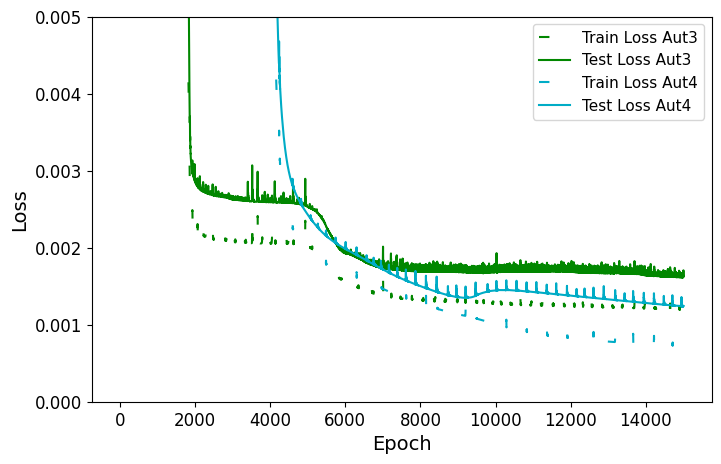

In [8]:
# Plotting train and test loss over epochs 

fig, ax = plt.subplots(1,1,figsize=[8,5])

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
epochs = range(1, num_epochs + 1)
lcolors=sns.color_palette(cc.glasbey,len(Autoencoders))     
i=1
dash_pattern=(5,35)

for column1,column2,color in zip(train_losses_df.columns.values[:4],test_losses_df.columns.values[:4], lcolors):
    if i>2:
        #sns.scatterplot(data=train_losses_df,x='epochs', y=column1, label=f'Train Loss Aut{i}',ax=ax,s=1,color=color)
        sns.lineplot(data=train_losses_df, x='epochs', y=column1, label=f'Train Loss Aut{i}', ax=ax, color=color, dashes=dash_pattern)
        sns.lineplot(data=test_losses_df,x='epochs', y=column2, label=f'Test Loss Aut{i}',ax=ax,color=color)
        ax.set_ylim(0, 0.005)
    i+=1

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=11)

110 (100, 111)


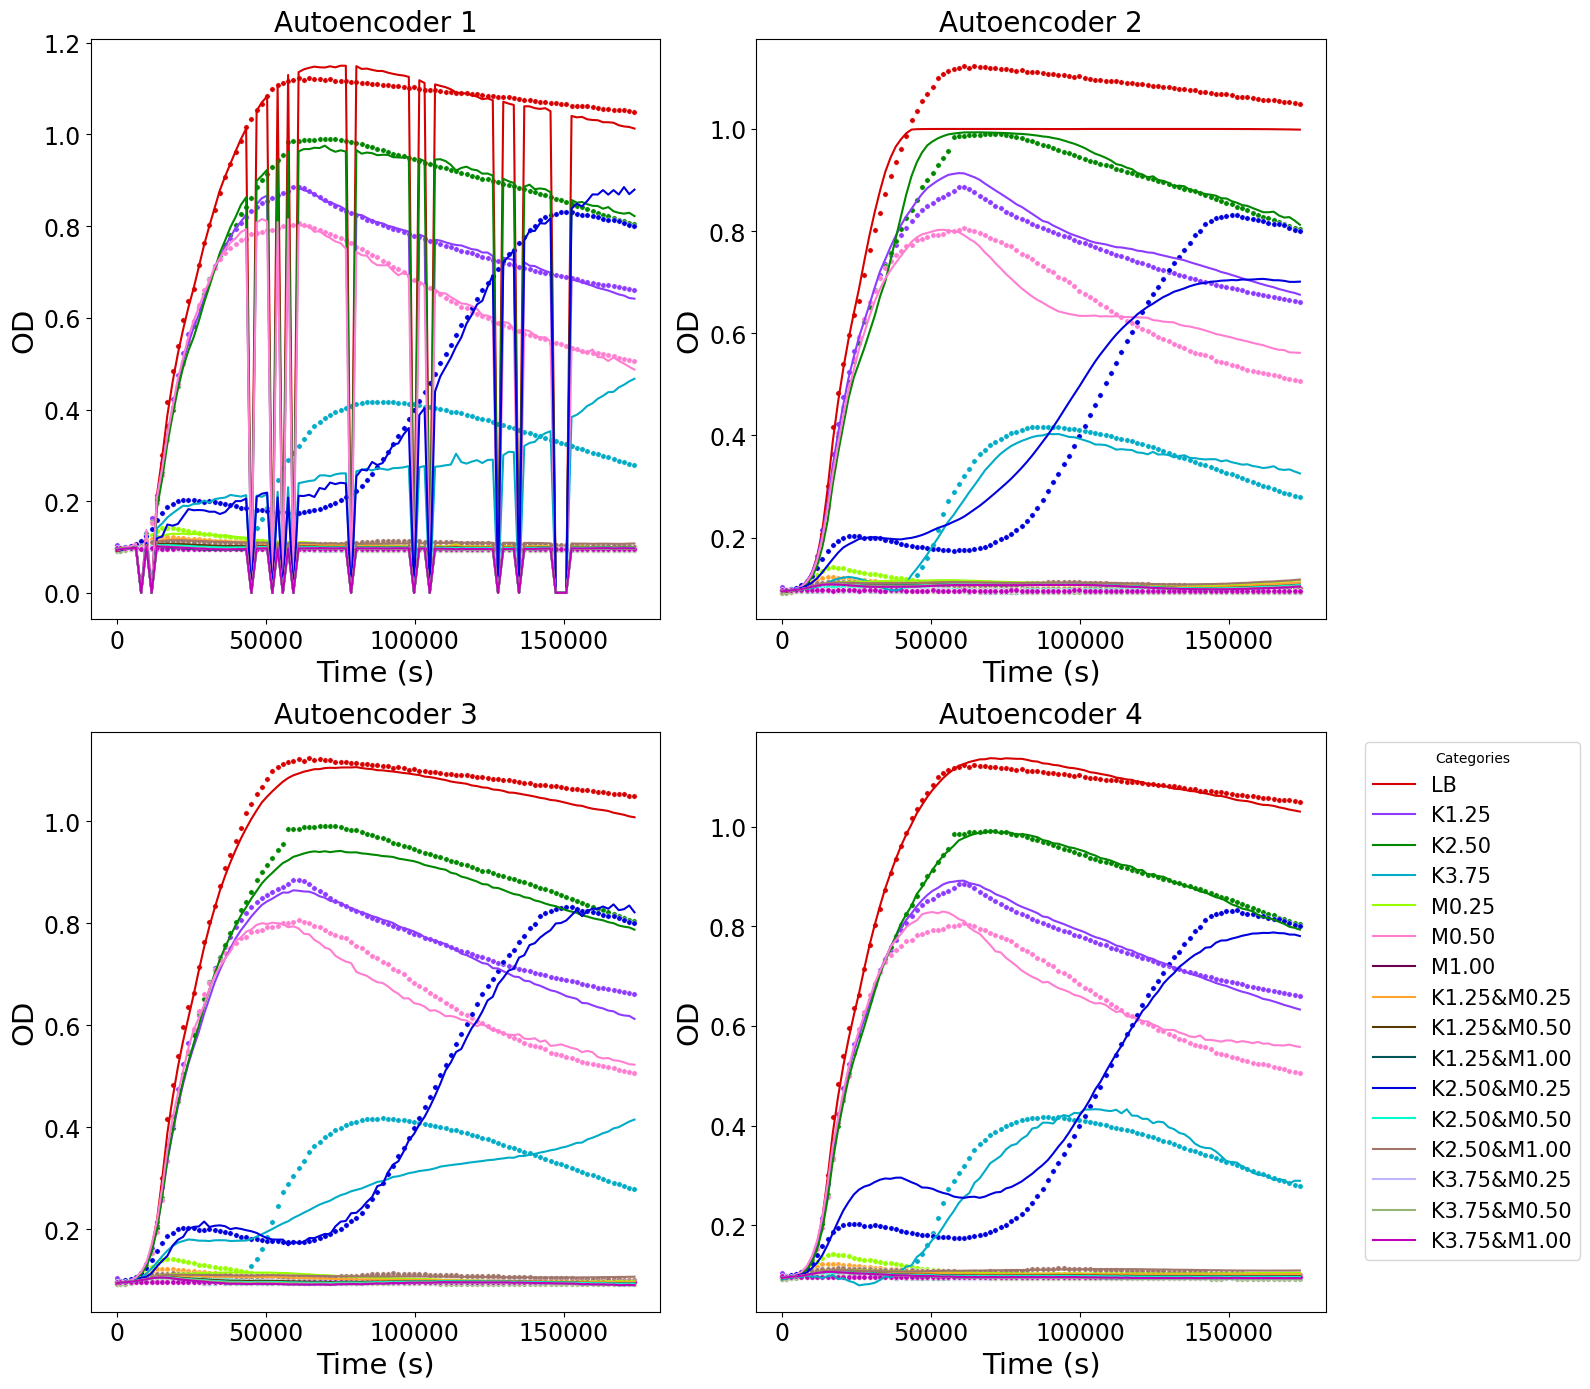

In [8]:
#Plotting the decoded vectors
fig, ax = plt.subplots(2,2,figsize=[16,14])
custom_palette=sns.color_palette(cc.glasbey,len(experiments2))
titles = ["Autoencoder 1", "Autoencoder 2", "Autoencoder 3", "Autoencoder 4"]

print(len(batches_test),test_data.shape)        
columns2=test_data.columns[:len(batches_test)]
num_list2 = list(range(len(batches_test)))
test_data2=pd.DataFrame()
batches_test2=[]
np.random.seed(4)

#take only one curve from each experiment to not overcharge the plot
for experiment in experiments2:
    columns_to_select=[]
    for batch,i in zip(batches_test,num_list2):
        if batch==experiment:
            columns_to_select.append(columns2[i])    
    test_columns = np.random.choice(columns_to_select,1,replace=False)
    batches_test2.append(experiment)
    test_columns_data = total_data[test_columns]
    test_data2 = pd.concat([test_data2, test_columns_data], axis=1)

#transform the subset test in a tensor, encode it and decode it
test_data2_T=test_data2.T
X_test2=test_data2_T.values
X_test_tensor2 = torch.FloatTensor(X_test2)

for model, ax, title in zip(trained_models, ax.flatten(),titles):
    # Encoding and decoding the data using the trained autoencoder
    encoded_test_data2 = model.encoder(X_test_tensor2).detach().numpy()
    decoded_test_df2= pd.DataFrame(model.decoder(torch.tensor(encoded_test_data2)).detach().numpy())
    decoded_test_df2=decoded_test_df2.T

    decoded_test_df2['Time [s]'] = Time
    test_data2['Time [s]'] = Time
    
    for column,column2,color,batch in zip(decoded_test_df2.columns.values[:len(batches_test2)],test_data2.columns.values[:len(batches_test2)], custom_palette,batches_test2):
        sns.lineplot(data=decoded_test_df2, x='Time [s]', y=column, ax=ax, color=color, label=batch)
        sns.scatterplot(data=test_data2, x='Time [s]', y=column2, ax=ax, color=color,s=15)
        
    ax.legend().remove()  # Remove individual legends
    ax.set_title(title,fontsize=20)  # Set title for each subplot
    ax.set_ylabel('OD',fontsize=21)
    ax.set_xlabel('Time (s)', fontsize=21)
    ax.set_xticks(range(0, 175000, 50000))
    ax.tick_params(axis='both', which='major', labelsize=17)

# Creating a single legend
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left',prop={'size': 15})  #legend outside of the plot
plt.tight_layout()  # Adjust layout to make room for the legend

plt.show()

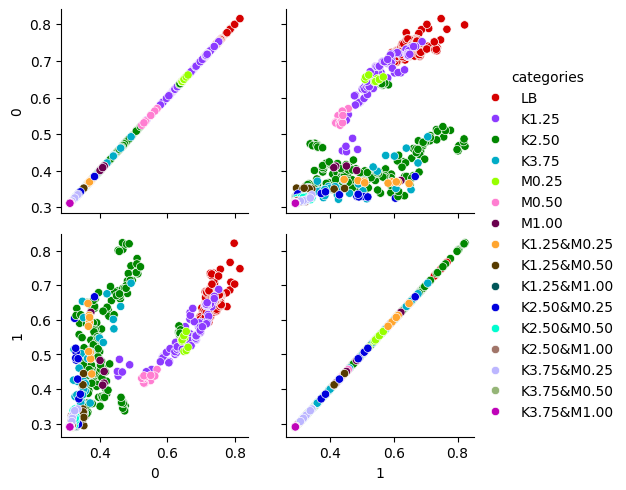

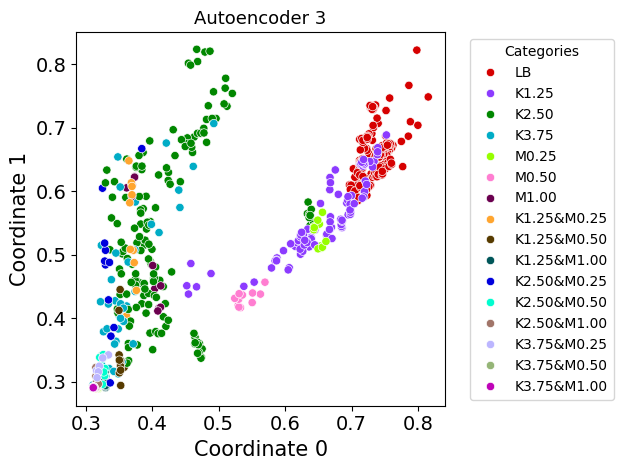

In [15]:
j=2
model=trained_models[j]
# Encoding the data using the trained autoencoder
encoded_train_data = model.encoder(X_train_tensor).detach().numpy()
encoded_test_data = model.encoder(X_test_tensor).detach().numpy()

encoded_test_df = pd.DataFrame(encoded_test_data)
encoded_train_df = pd.DataFrame(encoded_train_data)
dataset_df=pd.concat([encoded_test_df,encoded_train_df], ignore_index=True)
dataset_batches=np.concatenate((batches_test, batches_train))

dataset_df['categories']=dataset_batches

#drug='K1.25&M0.50'
#index_drug=experiments2.index(drug)
#filtered_df = dataset_df[dataset_df['categories'] == drug]
#palette=sns.color_palette(cc.glasbey,len(experiments2))
#palette=[palette[index_drug]]
#print(filtered_df)
#g = sns.PairGrid(filtered_df, hue='categories',palette=palette)
g = sns.PairGrid(dataset_df,hue='categories',palette=custom_palette)
g.map(sns.scatterplot)
g.add_legend()

x_col = g.x_vars[0]  # The x variable for the subplot at (1, 0)
y_col = g.y_vars[1]  # The y variable for the subplot at (1, 0)
data_subset = dataset_df[[x_col, y_col, 'categories']]

# Plot the extracted data in a new figure
plt.figure()
sns.scatterplot(data=data_subset, x=x_col, y=y_col, hue='categories', palette=custom_palette)
plt.xlabel('Coordinate 0', fontsize=15)
plt.ylabel('Coordinate 1', fontsize=15)
plt.title(f'Autoencoder {j+1}',fontsize=13)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=10)  #legend outside of the plot
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


